<a href="https://colab.research.google.com/github/pruhnav/LoadForecasting/blob/main/Price_forecast_XGBoost%2C_BiLSTM%2C_LSTM%2C_GRU%2C_Transformer%2C_CNN%2C_Hybrid_48h_12t_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy Price Prediction with XGBoost & BiLSTM

# Task for reza
- Make the progam to forecast 24 hours of prices at once.
- Change the input from t = 24, 24*3, 24*5, 24*7, 24*9, 24*11.
- Input for others 24*7, Output t = 24.
- See link: https://ieeexplore-ieee-org.ezaccess.libraries.psu.edu/stamp/stamp.jsp?tp=&arnumber=10214317
- Create Fig. 10 for MAE (Mean Absulute Error) and RMSE (Root Mean Squared Error) for Test data set (Proposed Hybrid Model).
- Two cases comparison (Actual vs Predcited): Best and Worst week.
- Whole year (2023) Actual vs Predicted and (Residual = Actual - Predicted)


In [1]:
from google.colab import files

# Open file upload dialog
#uploaded = files.upload()

In [2]:
import pandas as pd

# Load the uploaded Excel file
df = pd.read_excel('day_ahead_energy_prices.xlsx')

# Display the first few rows of the DataFrame
print(df.head())


                 Date  Price
0 2016-01-01 00:00:00  30.19
1 2016-01-01 01:00:00  25.35
2 2016-01-01 02:00:00  21.12
3 2016-01-01 03:00:00  21.07
4 2016-01-01 04:00:00  22.44


In [3]:
df.head()

,Date,Price
0,2016-01-01 00:00:00,30.19
1,2016-01-01 01:00:00,25.35
2,2016-01-01 02:00:00,21.12
3,2016-01-01 03:00:00,21.07
4,2016-01-01 04:00:00,22.44


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [5]:
# Assuming `df` is your DataFrame containing 'Date' and 'Price'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [6]:


# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create data structure for BiLSTM
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def prepare_data(data, look_back=48, look_ahead=12):
  X, y = [], []
  for i in range(len(data) - look_back - look_ahead + 1):
    X.append(data[i:(i + look_back)])
    y.append(data[(i + look_back):(i + look_back + look_ahead)])
  return np.array(X), np.array(y)


#X, y = create_dataset(scaled_data)
X, y = prepare_data(scaled_data)
X.shape,y.shape

((70069, 48, 1), (70069, 12, 1))

In [7]:
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for BiLSTM input

# Split into training and testing sets based on year
train_df = df[df.index.year <= 2022]
test_df = df[df.index.year == 2023]
train_scaled = scaler.transform(train_df['Price'].values.reshape(-1, 1))
test_scaled = scaler.transform(test_df['Price'].values.reshape(-1, 1))

X_train, y_train = prepare_data(train_scaled)
X_test, y_test = prepare_data(test_scaled)


In [8]:

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(61309, 48, 1) (61309, 12, 1)
(8701, 48, 1) (8701, 12, 1)


In [10]:
EPOCH = 3 # change here

In [11]:

# Build BiLSTM Model
def build_bilstm_model(input_shape, lstm_units=64, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(lstm_units, return_sequences=False))(inputs)

    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(12)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

bilstm_model = build_bilstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

In [12]:
# prompt: create xgboost model function

def create_xgboost_model(X_train, y_train):
  """Creates and trains an XGBoost model.

  Args:
    X_train: Training input data.
    y_train: Training target data.

  Returns:
    Trained XGBoost model.
  """
  xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
  xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
  return xgb_model


In [13]:
# Train BiLSTM

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCH,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/3
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0011 - val_loss: 8.7689e-04
Epoch 2/3
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 6.1268e-04 - val_loss: 7.3674e-04
Epoch 3/3
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 5.5440e-04 - val_loss: 6.8161e-04


In [14]:
# prompt: see layers of bilstm_model

bilstm_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,558 (607.65 KB)

 Trainable params: 51,852 (202.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,706 (405.11 KB)

In [15]:
# prompt: apply the bilstm model and give the mse, rmse, mae, smape, and r^2 score

# Predict using BiLSTM
y_pred_bilstm = bilstm_model.predict(X_test)

# Inverse transform the predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_bilstm_inv = scaler.inverse_transform(y_pred_bilstm.reshape(-1, 1))

# Calculate evaluation metrics
mse_bilstm = mean_squared_error(y_test_inv, y_pred_bilstm_inv)
rmse_bilstm = np.sqrt(mse_bilstm)
mae_bilstm = mean_absolute_error(y_test_inv, y_pred_bilstm_inv)

# SMAPE calculation
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape_bilstm = smape(y_test_inv, y_pred_bilstm_inv)

r2_bilstm = r2_score(y_test_inv, y_pred_bilstm_inv)

print(f"BiLSTM - MSE: {mse_bilstm:.4f}")
print(f"BiLSTM - RMSE: {rmse_bilstm:.4f}")
print(f"BiLSTM - MAE: {mae_bilstm:.4f}")
print(f"BiLSTM - SMAPE: {smape_bilstm:.4f}")
print(f"BiLSTM - R^2 Score: {r2_bilstm:.4f}")


272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
BiLSTM - MSE: 187.2823
BiLSTM - RMSE: 13.6851
BiLSTM - MAE: 6.5551
BiLSTM - SMAPE: 16.0191
BiLSTM - R^2 Score: 0.7304


In [16]:
# prompt: apply the xgboost model and give the mse, rmse, mae, smape, and r^2 score

# Train XGBoost
xgb_model = create_xgboost_model(X_train, y_train)

# Predict using XGBoost
y_pred_xgb = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))


# Inverse transform the predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_xgb_inv = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test_inv, y_pred_xgb_inv)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test_inv, y_pred_xgb_inv)
smape_xgb = smape(y_test_inv, y_pred_xgb_inv)
r2_xgb = r2_score(y_test_inv, y_pred_xgb_inv)

print(f"XGBoost - MSE: {mse_xgb:.4f}")
print(f"XGBoost - RMSE: {rmse_xgb:.4f}")
print(f"XGBoost - MAE: {mae_xgb:.4f}")
print(f"XGBoost - SMAPE: {smape_xgb:.4f}")
print(f"XGBoost - R^2 Score: {r2_xgb:.4f}")


XGBoost - MSE: 170.0347
XGBoost - RMSE: 13.0397
XGBoost - MAE: 5.3885
XGBoost - SMAPE: 12.1821
XGBoost - R^2 Score: 0.7552


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(48, 1)))  # assuming univariate input
lstm_model.add(Dense(12))  # 6-hour forecast
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,676 (69.05 KB)

 Trainable params: 17,676 (69.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 8.6803e-04 - val_loss: 0.0049
Epoch 2/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.4771e-04 - val_loss: 0.0040
Epoch 3/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.4604e-04 - val_loss: 0.0037
Epoch 4/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.2123e-04 - val_loss: 0.0034
Epoch 5/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.9936e-04 - val_loss: 0.0029
Epoch 6/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.6737e-04 - val_loss: 0.0033
Epoch 7/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.5205e-04 - val_loss: 0.0029
Epoch 8/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.4330e-04 - val_loss: 0.0027
Epoch 9/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.3568e-04 - val_loss: 0.0030
Epoch 10/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.2846e-04 - val_loss: 0.0031
Epoch 11/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.266

In [18]:
from tensorflow.keras.layers import GRU

gru_model = Sequential()
gru_model.add(GRU(64, activation='relu', input_shape=(48, 1)))
gru_model.add(Dense(12))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.summary()

gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,644 (53.30 KB)

 Trainable params: 13,644 (53.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 9.1958e-04 - val_loss: 0.0046
Epoch 2/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 4.3578e-04 - val_loss: 0.0044
Epoch 3/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.0123e-04 - val_loss: 0.0043
Epoch 4/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.2422e-04 - val_loss: 0.0042
Epoch 5/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.1875e-04 - val_loss: 0.0039
Epoch 6/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.9176e-04 - val_loss: 0.0034
Epoch 7/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.9928e-04 - val_loss: 0.0034
Epoch 8/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.7955e-04 - val_loss: 0.0032
Epoch 9/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.8277e-04 - val_loss: 0.0032
Epoch 10/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 2.7291e-04 - val_loss: 0.0033
Epoch 11/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.528

In [19]:
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model

inputs = Input(shape=(48, 1))
x = Dense(64)(inputs)
x = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(12)(x)

transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer='adam', loss='mse')
transformer_model.summary()

transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 48, 64)    │        128 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 64)    │     16,640 │ dense_4[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 48, 64)    │        128 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 48, 64)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ dropout_2[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 12)        │        780 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,676 (69.05 KB)

 Trainable params: 17,676 (69.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0013 - val_loss: 0.0053
Epoch 2/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 6.7523e-04 - val_loss: 0.0058
Epoch 3/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.5428e-04 - val_loss: 0.0053
Epoch 4/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.3883e-04 - val_loss: 0.0052
Epoch 5/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.4289e-04 - val_loss: 0.0052
Epoch 6/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6.5597e-04 - val_loss: 0.0054
Epoch 7/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.2941e-04 - val_loss: 0.0053
Epoch 8/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.2249e-04 - val_loss: 0.0052
Epoch 9/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6.2129e-04 - val_loss: 0.0052
Epoch 10/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.1538e-04 - val_loss: 0.0053
Epoch 11/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.1786e-04 -

In [20]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(48, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(12))
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.summary()

cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 46, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        94,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,308 (372.30 KB)

 Trainable params: 95,308 (372.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.8756e-04 - val_loss: 0.0024
Epoch 2/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 2.4564e-04 - val_loss: 0.0025
Epoch 3/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.3956e-04 - val_loss: 0.0024
Epoch 4/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.2766e-04 - val_loss: 0.0022
Epoch 5/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.1979e-04 - val_loss: 0.0023
Epoch 6/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.1129e-04 - val_loss: 0.0022
Epoch 7/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.0395e-04 - val_loss: 0.0024
Epoch 8/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.0646e-04 - val_loss: 0.0024
Epoch 9/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.0291e-04 - val_loss: 0.0022
Epoch 10/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.0508e-04 - val_loss: 0.0026
Epoch 11/20
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.0263e-04 - val

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

def evaluate_model(model, X_test, y_test, scaler=None, model_name="Model"):
    y_pred = model.predict(X_test)

    y_test = np.squeeze(y_test)
    y_pred = np.squeeze(y_pred)

    # Inverse scale if scaler is given
    if scaler:
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    smape_score = smape(y_test, y_pred)

    print(f"{model_name} - MSE: {mse:.4f}")
    print(f"{model_name} - RMSE: {rmse:.4f}")
    print(f"{model_name} - MAE: {mae:.4f}")
    print(f"{model_name} - SMAPE: {smape_score:.2f}%")
    print(f"{model_name} - R^2 Score: {r2:.4f}")


In [22]:
evaluate_model(lstm_model, X_test, y_test, scaler=scaler, model_name="LSTM")
evaluate_model(gru_model, X_test, y_test, scaler=scaler, model_name="GRU")
evaluate_model(transformer_model, X_test, y_test, scaler=scaler, model_name="Transformer")
evaluate_model(cnn_model, X_test, y_test, scaler=scaler, model_name="CNN")


272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
LSTM - MSE: 210.7022
LSTM - RMSE: 14.5156
LSTM - MAE: 6.3022
LSTM - SMAPE: 14.91%
LSTM - R^2 Score: 0.6967
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
GRU - MSE: 208.2224
GRU - RMSE: 14.4299
GRU - MAE: 6.4123
GRU - SMAPE: 15.19%
GRU - R^2 Score: 0.7003
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Transformer - MSE: 430.9060
Transformer - RMSE: 20.7583
Transformer - MAE: 10.3853
Transformer - SMAPE: 24.36%
Transformer - R^2 Score: 0.3797
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN - MSE: 231.5602
CNN - RMSE: 15.2171
CNN - MAE: 7.0661
CNN - SMAPE: 18.68%
CNN - R^2 Score: 0.6667


In [ ]:
import pandas as pd

# Updated evaluation metrics including CNN R²
data = {
    "Model": ["Hybrid", "LSTM", "GRU", "Transformer", "CNN", "XGBoost", "BiLSTM"],
    "MSE": [190.1436, 210.7022, 208.2224, 430.9060, 231.5602, 170.0347, 187.2823],
    "RMSE": [13.7893, 14.5156, 14.4299, 20.7583, 15.2171, 13.0397, 13.6851],
    "MAE": [5.8692, 6.3022, 6.4123, 10.3853, 7.0661, 5.3885, 6.5551],
    "SMAPE": [13.4764, 14.91, 15.19, 24.36, 18.68, 12.1821, 16.0191],
    "R2": [0.7263, 0.6967, 0.7003, 0.3797, 0.6667, 0.7552, 0.7304]
}

# Create the DataFrame
df_results = pd.DataFrame(data)

# Display the DataFrame
print(df_results)


### Task - HYBRID MODEL
input 24, 48, 72, 96

change the feature to 30, 60, 90, 120

In [23]:
# Extract Features from BiLSTM
intermediate_layer_model = Model(inputs=bilstm_model.input, outputs=bilstm_model.layers[-2].output)
bilstm_features_train = intermediate_layer_model.predict(X_train)
bilstm_features_test = intermediate_layer_model.predict(X_test)

1916/1916 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [24]:
bilstm_features_train.shape,bilstm_features_test.shape

((61309, 128), (8701, 128))

In [25]:
# sMAPE Calculation
def calculate_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # handle the case where both prediction and actual are zero
    return 100 * np.mean(diff)



# Modified MAPE Calculation (exclude zero values in actual prices)
def calculate_mape(y_true, y_pred):
    non_zero_mask = y_true != 0  # Exclude zero actual values
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

In [26]:
evaluation_data = pd.DataFrame(columns=['Model', 'MAPE', 'RMSE', 'MAE', 'R2'])
def evaluation_metrics(y_test_original, y_pred_original, model_name="No Model"):
  mae = mean_absolute_error(y_test_original, y_pred_original)
  rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
  mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
  r2 = r2_score(y_test_original, y_pred_original)


  #print(f"Mean Absolute Percentage Error (MAPE): {mape*100}")
  #print(f"RMSE: {rmse}")
  #print(f"Mean Absolute Error (MAE): {mae}")
  #print(f"R-squared (R2): {r2}")
  # Create a new row as a dictionary
  new_row = {'Model': model_name, 'MAPE': mape*100 , 'RMSE': rmse , 'MAE': mae , 'R2': r2 }
  global evaluation_data;
  # Add the new row using the loc indexer
  evaluation_data.loc[model_name] = new_row
  #print(evaluation_data)

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [28]:
# Train XGBoost with BiLSTM Features
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
y_train_reshaped = y_train.reshape(y_train.shape[0], -1)  # Reshape to (num_samples, 24)
xgb_model.fit(bilstm_features_train, y_train_reshaped, verbose=True)



# Save Actual vs Predicted Prices in Excel
#results_df = pd.DataFrame({
 #   'Date': test_df.index[-len(xgb_predictions):],
  #  'Actual Price': test_actual.flatten(),
   # 'Predicted Price': xgb_predictions_rescaled.flatten()
#})
#results_df.to_excel('actual_vs_predicted.xlsx', index=False)
#print("Actual vs Predicted saved to 'actual_vs_predicted.xlsx'.")




XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [29]:

# Make Predictions with XGBoost
xgb_predictions = xgb_model.predict(bilstm_features_test)
xgb_predictions_rescaled = scaler.inverse_transform(xgb_predictions.reshape(-1, 6))

# Rescale Test Data
test_actual = scaler.inverse_transform(y_test.reshape(-1, 6))

In [30]:
evaluation_metrics(test_actual, xgb_predictions_rescaled, f"XGBoost_look_back_48_hour")
evaluation_data

,Model,MAPE,RMSE,MAE,R2
XGBoost_look_back_48_hour,XGBoost_look_back_48_hour,1.318817e+15,13.789255,5.869233,0.726285


In [31]:
test_actual

array([[30.43, 29.37, 27.72, 26.64, 27.72, 30.04],
       [37.34, 44.16, 44.85, 43.66, 41.79, 42.06],
       [29.37, 27.72, 26.64, 27.72, 30.04, 37.34],
       ...,
       [40.16, 36.43, 32.1 , 29.61, 27.98, 25.51],
       [24.72, 24.98, 25.08, 26.95, 33.44, 40.16],
       [36.43, 32.1 , 29.61, 27.98, 25.51, 25.79]])

In [32]:
xgb_predictions_rescaled

array([[33.98217 , 33.707607, 33.186714, 34.650932, 35.29046 , 36.42945 ],
       [38.325447, 39.048573, 38.88342 , 37.414326, 37.086243, 38.869625],
       [28.449505, 29.930605, 30.840048, 33.050713, 34.614365, 36.091576],
       ...,
       [33.808132, 32.853233, 30.920687, 28.687748, 26.800032, 25.34855 ],
       [25.731955, 25.932003, 27.44382 , 29.770422, 32.27397 , 33.526024],
       [33.40678 , 30.90375 , 28.71715 , 26.999573, 25.249344, 24.498844]],
      dtype=float32)

In [33]:
# prompt: find the difference between test_actual and xgb_predictions_rescaled where  every item comparison difference is more than 10

# Find differences greater than 10
differences = np.abs(test_actual - xgb_predictions_rescaled)
indices = np.where(differences > 10)

# Print the indices and values where the difference is greater than 10
print("Indices where the difference is greater than 10:")
print(indices)

print("\nDifferences greater than 10:")
print(differences[indices])

# Access the corresponding values from test_actual and xgb_predictions_rescaled
print("\nValues from test_actual:")
print(test_actual[indices])

print("\nValues from xgb_predictions_rescaled:")
xgb_predictions_rescaled[indices]


Indices where the difference is greater than 10:
(array([    8,     9,     9, ..., 17011, 17013, 17013]), array([4, 2, 3, ..., 3, 2, 3]))

Differences greater than 10:
[10.87209473 10.97482803 10.19953308 ... 11.32650467 10.92206665
 10.87020081]

Values from test_actual:
[44.85 42.53 43.35 ... 33.04 33.04 31.32]

Values from xgb_predictions_rescaled:


array([33.977905, 31.555172, 33.150467, ..., 44.366505, 43.962067,
       42.1902  ], dtype=float32)

In [34]:
# Evaluation Metrics
mse = mean_squared_error(test_actual, xgb_predictions_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_actual, xgb_predictions_rescaled)
r2 = r2_score(test_actual, xgb_predictions_rescaled)

smape = calculate_smape(test_actual, xgb_predictions_rescaled)

mape = mean_absolute_percentage_error(test_actual, xgb_predictions_rescaled)

print(f"Hybrid Model Evaluation:\nMAE: {mae}, RMSE: {rmse}, sMAPE: {smape}%, MAPE: {mape}, R^2: {r2}, MSE: {mse}")


Hybrid Model Evaluation:
MAE: 5.869232787094759, RMSE: 13.78925526489865, sMAPE: 13.476406246101558%, MAPE: 13188168610641.732, R^2: 0.7262845582575368, MSE: 190.1435607605351


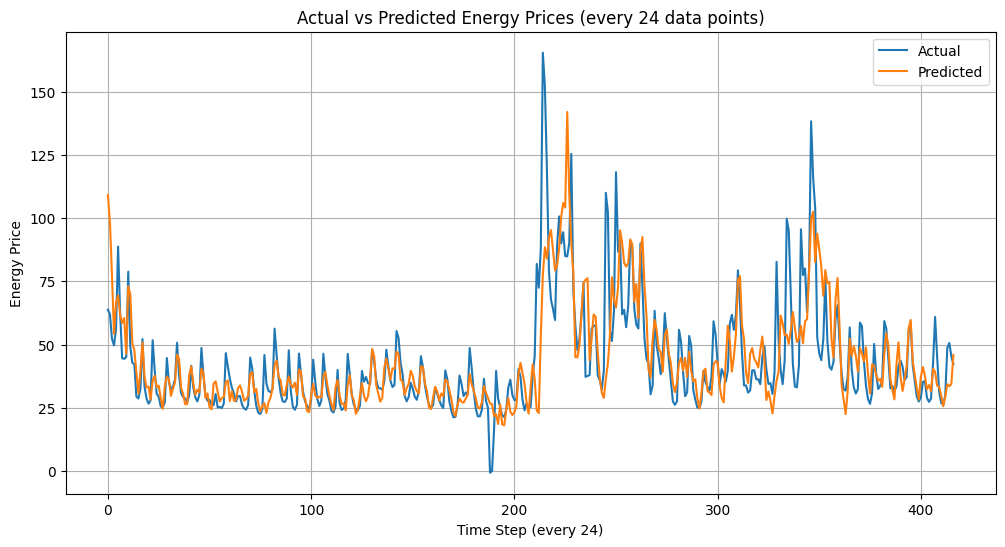

In [35]:
# prompt: draw a line graph based test_actual and xgb_predictions_rescaled data every 24 data

import matplotlib.pyplot as plt

# Assuming xgb_predictions_rescaled and test_actual are already defined

# Plotting every 24th data point
plt.figure(figsize=(12, 6))
plt.plot(test_actual.flatten()[10000:20000:24], label='Actual')
plt.plot(xgb_predictions_rescaled.flatten()[10000:20000:24], label='Predicted')
plt.xlabel('Time Step (every 24)')
plt.ylabel('Energy Price')
plt.title('Actual vs Predicted Energy Prices (every 24 data points)')
plt.legend()
plt.grid(True)
plt.show()


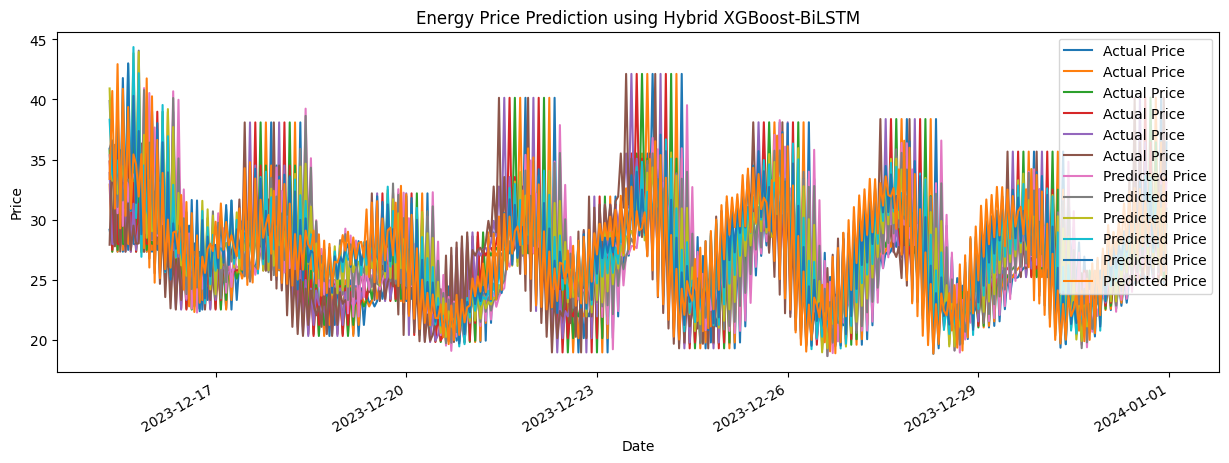

In [36]:
# Visualization
SHOW_TEST_VALUES = 400

plt.figure(figsize=(15, 5))
plt.plot(test_df.index[-SHOW_TEST_VALUES:], test_actual[-SHOW_TEST_VALUES:], label='Actual Price')
plt.plot(test_df.index[-SHOW_TEST_VALUES:], xgb_predictions_rescaled[-SHOW_TEST_VALUES:], label='Predicted Price')
plt.title('Energy Price Prediction using Hybrid XGBoost-BiLSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))#'%Y-%m-%d %H:%M
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig("Energy Price Prediction(proposed).pdf", bbox_inches='tight')
plt.show()

In [37]:
print("Extracted Features (Training):")
print(bilstm_features_train)

Extracted Features (Training):
[[0.         0.00761053 0.         ... 0.02929952 0.         0.        ]
 [0.         0.00653349 0.         ... 0.02391286 0.         0.        ]
 [0.         0.00389354 0.         ... 0.02143941 0.         0.        ]
 ...
 [0.02761195 0.01479219 0.         ... 0.         0.         0.        ]
 [0.02117359 0.         0.         ... 0.         0.         0.        ]
 [0.01478848 0.         0.         ... 0.         0.         0.02229349]]


In [38]:
training_features_df = pd.DataFrame(bilstm_features_train)
# training_features_df.to_excel('bilstm_features_train.xlsx', index=False) %%


To apply SHAP (SHapley Additive exPlanations) to a hybrid model combining BiLSTM and XGBoost, you need to follow a structured approach depending on how you integrate both models. Typically, this hybrid approach consists of two stages:

Feature Extraction using BiLSTM: A BiLSTM (Bidirectional Long Short-Term Memory) network processes sequential data and extracts meaningful features.
Prediction using XGBoost: The extracted features are then passed to an XGBoost model for final predictions.
## Applying SHAP to this Hybrid Model
Since SHAP explanations depend on the model type, you need to determine whether to explain the BiLSTM model, the XGBoost model, or both

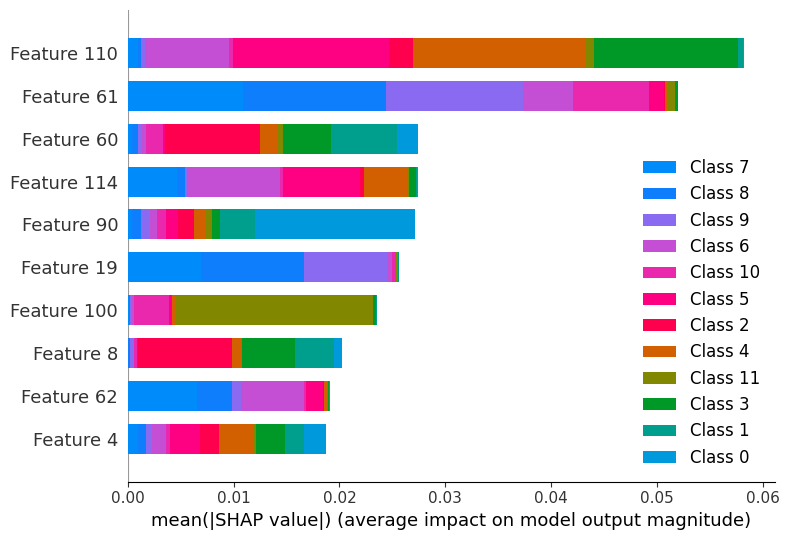

In [39]:
import shap
# Explain XGBoost predictions using SHAP values
explainer = shap.Explainer(xgb_model)
shap_values = explainer(bilstm_features_test)

# Visualize SHAP values
shap.summary_plot(shap_values, bilstm_features_test, plot_type="bar",max_display=10,show=False)
plt.savefig("shap_summary_plot_bilstm_features_bar_graph.pdf", bbox_inches='tight')
plt.show()

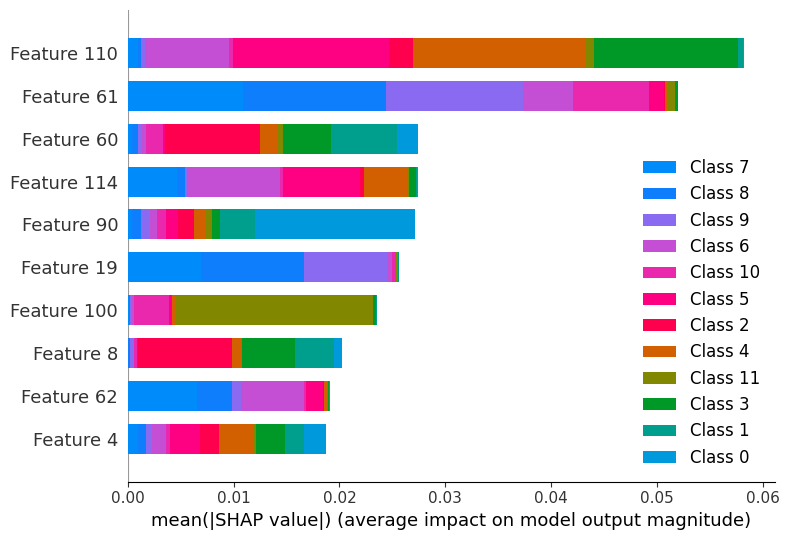

In [40]:

shap.summary_plot(shap_values, bilstm_features_test,max_display=10,show=False)
plt.savefig("shap_summary_plot_bilstm_features.pdf", bbox_inches='tight')
plt.show()

In [41]:
X_train_temp = X_train.reshape(X_train.shape[0],-1)
X_test_temp = X_test.reshape(X_test.shape[0],-1)
num_features = X_train_temp.shape[1]

# Generate column names (Modify this based on actual feature names)
feature_names = [f"t-{60-i}" for i in range(num_features)]  # Default names
X_train_df = pd.DataFrame(X_train_temp, columns=feature_names)
X_test_df = pd.DataFrame(X_test_temp, columns=feature_names)

In [42]:
NUM_ROWS = 500
explainer_bilstm = shap.Explainer(bilstm_model, X_train_df[:NUM_ROWS])  # Sample subset for efficiency
shap_values_bilstm = explainer_bilstm(X_test_df[:NUM_ROWS])




PermutationExplainer explainer: 501it [04:15,  1.91it/s]


In [43]:
#shap.summary_plot(shap_values_bilstm, X_test_df, plot_type="bar",max_display=10,show=False)

#plt.savefig("shap_summary_plot_bilstm_average_impact.pdf", bbox_inches='tight')
#plt.show()


<ipython-input-44-06702a10f7d5>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_bilstm, X_test_df[:NUM_ROWS], max_display=10,show=False)


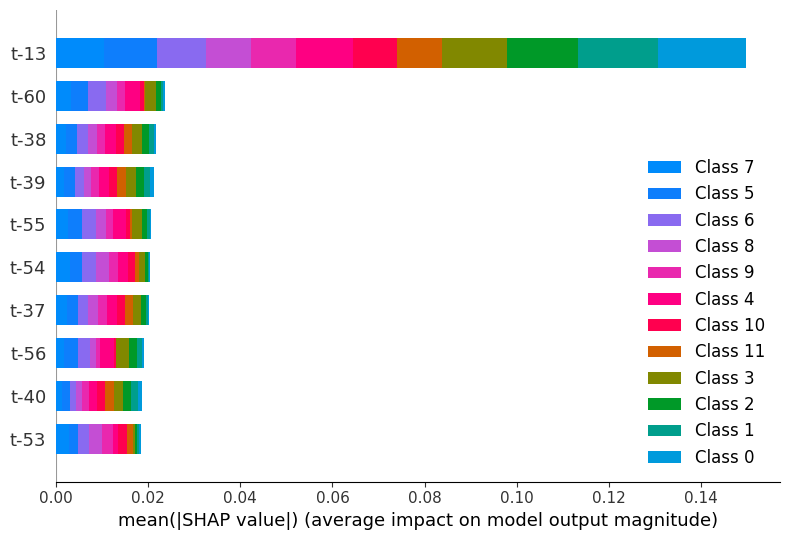

In [44]:
# Visualize the SHAP values for BiLSTM

shap.summary_plot(shap_values_bilstm, X_test_df[:NUM_ROWS], max_display=10,show=False)


plt.savefig("shap_summary_plot_bilstm_impact_on_model_output.pdf", bbox_inches='tight')
plt.show()

#t-1, t-2 .....

In [45]:
shap.plots.waterfall(shap_values_bilstm[1],show=False)


plt.savefig("shap_summary_plot_bilstm_waterfall.pdf", bbox_inches='tight')
plt.show()


ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (48, 12)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [ ]:
shap.plots.bar(shap_values_bilstm,show=False)
plt.savefig("shap_summary_plot_bilstm_mean_shap_value.pdf", bbox_inches='tight')
plt.show()

In [ ]:

explainer_bilstm = shap.Explainer(bilstm_model, X_train_df[:10])
shap_values_bilstm = explainer_bilstm(X_test_df[:10])

# Instead of using explainer_bilstm.model.predict, use your original model:
expected_value = bilstm_model.predict(X_train_df[:10]).mean()

shap.decision_plot(expected_value, shap_values_bilstm[1].values, X_test_df.columns,show=False)
plt.savefig("shap_summary_plot_bilstm_model_output.pdf", bbox_inches='tight')
plt.show()

In [ ]:
shap.plots.beeswarm(shap_values_bilstm)